In [1]:
!pip install optuna
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import optuna
from optuna.trial import TrialState

torch.set_default_dtype(torch.float32)
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns

from urllib.request import urlretrieve

# Set the color scheme
sns.set_theme()
colors = [
    "#0076C2",
    "#EC6842",
    "#A50034",
    "#009B77",
    "#FFB81C",
    "#E03C31",
    "#6CC24A",
    "#EF60A3",
    "#0C2340",
    "#00B8C8",
    "#6F1D77",
]
plt.rcParams["axes.prop_cycle"] = cycler(color=colors)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 10.3 MB/s eta 0:00:00


In [2]:
def f_exact(x, t):
    return (1 - 16  * np.pi**2) * torch.sin(x) * torch.cos(4 * np.pi * t)

def u_exact(x, t):
    return torch.sin(x) * torch.cos(4 * np.pi * t)

In [3]:
def gen_data(L, t_end, n):
    x_vals = torch.rand(n) * L
    t_vals = torch.rand(n) * t_end
    return (x_vals, t_vals, f_exact(x_vals, t_vals), u_exact(x_vals, t_vals))

In [4]:
# training data generation
t_end = 1

x_gen, t_gen, f_gen, u_gen = gen_data(np.pi, t_end, 10000)
x_gen, t_gen, f_gen, u_gen = torch.tensor(x_gen, dtype=torch.float32), torch.tensor(t_gen, dtype=torch.float32), torch.tensor(f_gen, dtype=torch.float32), torch.tensor(u_gen, dtype=torch.float32)
# validation data generation
x_gen_val, t_gen_val, f_gen_val, u_gen_val = gen_data(np.pi, t_end, 1000)
x_gen_val, t_gen_val, f_gen_val, u_gen_val = torch.tensor(x_gen_val, dtype=torch.float32), torch.tensor(t_gen_val, dtype=torch.float32), torch.tensor(f_gen_val, dtype=torch.float32), torch.tensor(u_gen_val, dtype=torch.float32)

/tmp/ipython-input-54349312.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_gen, t_gen, f_gen, u_gen = torch.tensor(x_gen, dtype=torch.float32), torch.tensor(t_gen, dtype=torch.float32), torch.tensor(f_gen, dtype=torch.float32), torch.tensor(u_gen, dtype=torch.float32)
/tmp/ipython-input-54349312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_gen_val, t_gen_val, f_gen_val, u_gen_val = torch.tensor(x_gen_val, dtype=torch.float32), torch.tensor(t_gen_val, dtype=torch.float32), torch.tensor(f_gen_val, dtype=torch.float32), torch.tensor(u_gen_val, dtype=torch.float32)


In [5]:
# Class that normalizes data to follow Normal(0, 1) distribution.
class normUnitvar:
    def __init__(self, fullDataset):
        self.normmean = fullDataset.mean(axis=0)
        self.normstd = fullDataset.std(axis=0)

    def normalize(self, data):
        return (data - self.normmean) / self.normstd

    def denormalize(self, data):
        return data * self.normstd + self.normmean

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [7]:
# Create normalizers and normalize the data
x_normalizer = normUnitvar(x_gen)
t_normalizer = normUnitvar(t_gen)
f_normalizer = normUnitvar(f_gen)
u_normalizer = normUnitvar(u_gen)

x_norm = x_normalizer.normalize(x_gen)
t_norm = t_normalizer.normalize(t_gen)
f_norm = f_normalizer.normalize(f_gen)
u_norm = u_normalizer.normalize(u_gen)
# normalize validation data using the training normalizer
x_val_norm = x_normalizer.normalize(x_gen_val)
t_val_norm = t_normalizer.normalize(t_gen_val)
f_val_norm = f_normalizer.normalize(f_gen_val)
u_val_norm = u_normalizer.normalize(u_gen_val)

# Stack inputs (x, t, bias) and outputs (f, u) into N×3 and N×2 arrays
inputs_train_unnorm = torch.stack([x_gen, t_gen], dim=1).to(device)
outputs_train_unnorm = torch.stack([f_gen, u_gen], dim=1).to(device)
inputs_train = torch.stack([x_norm, t_norm], dim=1).to(device)  # Shape: [N, 3]
outputs_train = torch.stack([f_norm, u_norm], dim=1).to(device)  # Shape: [N, 2]
inputs_val = torch.stack([x_val_norm, t_val_norm], dim=1).to(device)  # Shape: [N_val, 3]
outputs_val = torch.stack([f_val_norm, u_val_norm], dim=1).to(device)  # Shape: [N_val, 2]

batch_size = 300
#training_dataset = torch.utils.data.TensorDataset(inputs_train, outputs_train)
validation_set = torch.utils.data.TensorDataset(inputs_val, outputs_val)

#train_loader = DataLoader(training_dataset, batch_size=batch_size)
validation_loader = DataLoader(validation_set, batch_size=batch_size)

# Model Definition

In [8]:
class MLP(nn.Module):
    "Defines a basic multi-layer perceptron."
    def __init__(self, input_size, hidden_size, output_size, num_hid_layers=4):
        super(MLP, self).__init__()
        # Define the layers of the network
        self.num_layers = num_hid_layers

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))

        for n in range(num_hid_layers):
            self.layers.append(nn.Linear(hidden_size, hidden_size))

        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x, ):
        # Define the forward pass
        for i, layer in enumerate(self.layers):
            x = F.tanh(layer(x))  # Activation function (Tanh) after each layer
        x = self.fc_out(x)          # Output layer
        return x

In [9]:
# set the seed for reproducibility
torch.manual_seed(123)

# Define parameters
L = np.pi
T_end = 1

# Set sample sizes
N_f = 10000 # collocation points in interior
N_ic = 2000 # initial condition samples at t=0
N_bc = 2000 # boundary samples at x=0 and x=L

# setup to train the PINN
n_epochs = 200

# compute each term of the PINN loss function using the following hyperparameters (these were optimized with Optuna):
lambda_data = 0.7525089756103733
lambda_ic = 0.718171287614217
lambda_bc = 1.5389272785744066
lambda_physics = 0.7048568176868526

# echo on screen
echo_every = 50

In [10]:
def evaluation(model, loader, loss_function):
    model.eval()  # specifies that the model is in evaluation mode
    losses = []

    # Remove gradients computations since we are only evaluating and not training
    with torch.no_grad():
        for batch in loader:
            # extract inputs x and outputs y from batch
            inputs, target = batch  # inputs: [batch_size, 2], target: [batch_size, 2]
            pred = model(inputs)
            # Extract only the u component from the target (second column) and unsqueeze to match pred shape
            target_u = target[:, 1].unsqueeze(1)
            loss = loss_function(pred, target_u)
            losses.append(loss.detach().item())

    return np.array(losses).mean()

In [11]:
def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 50, 500, step=50)
    learning_rate = trial.suggest_float('learning_rate', 5e-4, 1e-1, log=True)
    num_layers = trial.suggest_int('num_layers', 1, 4)

    pinn = MLP(2, hidden_size, 1, num_hid_layers=num_layers).to(device)
    optimiser = torch.optim.AdamW(pinn.parameters(), lr=learning_rate)

    max_trial_seconds = 120  # e.g., 2 minutes per trial

    start_time = time.perf_counter()


    for i in range(n_epochs+1):
        pinn.train()
        optimiser.zero_grad()

        # Resample all training points each iteration to avoid reusing graphs
        x_ic = (L * torch.rand(N_ic, 1, requires_grad=True)).to(device)
        t_ic = torch.zeros_like(x_ic, requires_grad=True).to(device)

        t_bc_left = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
        x_bc_left = torch.zeros_like(t_bc_left, requires_grad=True).to(device)

        t_bc_right = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
        x_bc_right = (L * torch.ones_like(t_bc_right, requires_grad=True)).to(device)

        x_f = (L * torch.rand(N_f, 1, requires_grad=True)).to(device)
        t_f = (T_end * torch.rand(N_f, 1, requires_grad=True)).to(device)


        #compute data loss
        # Use the pre-stacked inputs_train for pinn input
        u_pred_data = pinn(inputs_train)
        # The true u_norm is the second column of outputs_train; unsqueeze to match pinn's output shape (N,1)
        target_u_norm = outputs_train[:, 1].unsqueeze(1)
        loss_data = torch.mean(torch.abs(u_pred_data - target_u_norm))

        # initial condition
        u_norm = pinn(torch.cat([x_normalizer.normalize(x_ic), t_normalizer.normalize(t_ic)], dim=1))
        u_denorm = u_normalizer.denormalize(u_norm)
        u = u_denorm
        loss_ic_1 = torch.mean(torch.abs(u - torch.sin(x_ic)))
        dudt = torch.autograd.grad(u, t_ic, torch.ones_like(u), create_graph=True)[0]
        loss_ic_2 = torch.mean(torch.abs(dudt - 0))

        # boundary condition left
        u_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_left), t_normalizer.normalize(t_bc_left)], dim=1))
        u_denorm = u_normalizer.denormalize(u_norm)
        u = u_denorm
        loss_bc_left_1 = torch.mean(torch.abs(u - 0))
        dudx_bc_left = torch.autograd.grad(u, x_bc_left, torch.ones_like(u), create_graph=True)[0]
        d2udx2_bc_left = torch.autograd.grad(dudx_bc_left, x_bc_left, torch.ones_like(dudx_bc_left), create_graph=True)[0]
        loss_bc_left_2 = torch.mean(torch.abs(d2udx2_bc_left - 0))

        # boundary condition right
        u_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_right), t_normalizer.normalize(t_bc_right)], dim=1))
        u_denorm = u_normalizer.denormalize(u_norm)
        u = u_denorm
        loss_bc_right_1 = torch.mean(torch.abs(u - 0))
        dudx_bc_right = torch.autograd.grad(u, x_bc_right, torch.ones_like(u), create_graph=True)[0]
        d2udx2_bc_right = torch.autograd.grad(dudx_bc_right, x_bc_right, torch.ones_like(dudx_bc_right), create_graph=True)[0]
        loss_bc_right_2 = torch.mean(torch.abs(d2udx2_bc_right - 0))

        # compute physics loss
        EI = 1
        rhoA = 1
        u_f = pinn(torch.cat([x_normalizer.normalize(x_f), t_normalizer.normalize(t_f)], dim=1))
        u_f_denorm = u_normalizer.denormalize(u_f)
        u_f = u_f_denorm

        dudx_f = torch.autograd.grad(u_f, x_f, torch.ones_like(u_f), create_graph=True)[0]
        d2udx2_f = torch.autograd.grad(dudx_f, x_f, torch.ones_like(dudx_f), create_graph=True)[0]
        d3udx3_f = torch.autograd.grad(d2udx2_f, x_f, torch.ones_like(d2udx2_f), create_graph=True)[0]
        d4udx4_f = torch.autograd.grad(d3udx3_f, x_f, torch.ones_like(d3udx3_f), create_graph=True)[0]
        dudt_f = torch.autograd.grad(u_f, t_f, torch.ones_like(u_f), create_graph=True)[0]
        d2udt2_f = torch.autograd.grad(dudt_f, t_f, torch.ones_like(dudt_f), create_graph=True)[0]
        physics_residual = rhoA * d2udt2_f + EI * d4udx4_f - f_exact(x_f, t_f)
        loss_physics = torch.mean(torch.abs(physics_residual))

        # backpropagate joint loss, take optimiser step
        loss = lambda_data*loss_data + lambda_ic*loss_ic_1 + lambda_ic*loss_ic_2 + lambda_bc*loss_bc_left_1 + lambda_bc*loss_bc_left_2 + lambda_bc*loss_bc_right_1 + lambda_bc*loss_bc_right_2 + lambda_physics*loss_physics
        loss.backward()
        optimiser.step()

        # validation loss
        validation_loss = evaluation(pinn, validation_loader, nn.L1Loss())

        if i % (echo_every//5) == 0:
            intermediate_value = validation_loss
            trial.report(intermediate_value, i)

        # plot the result as training progresses (no grad tracking)
        if i % echo_every == 0:
            print(f"Epoch {i}: total loss = {loss}, validation_loss = {validation_loss:.6f}, loss_data = {loss_data}, loss_ic_1 = {loss_ic_1}, loss_ic_2 = {loss_ic_2}, loss_bc_left_1 = {loss_bc_left_1}, loss_bc_left_2 = {loss_bc_left_2}, loss_bc_right_1 = {loss_bc_right_1}, loss_bc_right_2 = {loss_bc_right_2}, loss_physics = {loss_physics}")
            print(f"Validation loss at epoch {i}: {validation_loss:.6f}")

            if i!=0 and trial.should_prune():
                print(" (Pruned) Params: ")
                for key, value in trial.params.items():
                    print("    {}: {}".format(key, value))
                raise optuna.TrialPruned()

        # Check if the trial has exceeded the maximum allowed time
        elapsed = time.perf_counter() - start_time
        if elapsed > max_trial_seconds:
            # Stop *this* trial only
            raise optuna.exceptions.TrialPruned()


    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    return validation_loss


In [12]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# print("Best Hyperparameters:", study.best_params)

[I 2026-01-29 14:34:29,191] A new study created in memory with name: no-name-10e6f2a9-3155-4f9e-966a-7d1fdc0ab691


Epoch 0: total loss = 46.29027557373047, validation_loss = 0.990569, loss_data = 0.8184416890144348, loss_ic_1 = 0.7303900718688965, loss_ic_2 = 0.05768004059791565, loss_bc_left_1 = 0.08296460658311844, loss_bc_left_2 = 0.010884584859013557, loss_bc_right_1 = 0.021026981994509697, loss_bc_right_2 = 0.011778496205806732, loss_physics = 63.72004699707031
Validation loss at epoch 0: 0.990569
Epoch 50: total loss = 38.47883224487305, validation_loss = 0.709103, loss_data = 0.8574548363685608, loss_ic_1 = 0.5981957316398621, loss_ic_2 = 0.026684869080781937, loss_bc_left_1 = 0.26897406578063965, loss_bc_left_2 = 0.08290011435747147, loss_bc_right_1 = 0.22678737342357635, loss_bc_right_2 = 0.039373449981212616, loss_physics = 51.689517974853516
Validation loss at epoch 50: 0.709103
Epoch 100: total loss = 39.02963638305664, validation_loss = 0.693369, loss_data = 0.7376805543899536, loss_ic_1 = 0.35735830664634705, loss_ic_2 = 0.8650082349777222, loss_bc_left_1 = 0.19394400715827942, loss_b

[I 2026-01-29 14:34:50,472] Trial 0 finished with value: 0.6748117804527283 and parameters: {'hidden_size': 50, 'learning_rate': 0.052042115952204225, 'num_layers': 3}. Best is trial 0 with value: 0.6748117804527283.


Epoch 200: total loss = 38.74078369140625, validation_loss = 0.674812, loss_data = 1.3933913707733154, loss_ic_1 = 0.38583531975746155, loss_ic_2 = 0.4893469214439392, loss_bc_left_1 = 0.541087806224823, loss_bc_left_2 = 0.18127109110355377, loss_bc_right_1 = 0.6319023966789246, loss_bc_right_2 = 0.16210833191871643, loss_physics = 49.27260208129883
Validation loss at epoch 200: 0.674812
  Params: 
    hidden_size: 50
    learning_rate: 0.052042115952204225
    num_layers: 3
Epoch 0: total loss = 46.43545913696289, validation_loss = 2.149545, loss_data = 0.8127637505531311, loss_ic_1 = 0.6299976110458374, loss_ic_2 = 0.01804656907916069, loss_bc_left_1 = 0.016287917271256447, loss_bc_left_2 = 0.004683427046984434, loss_bc_right_1 = 0.004223193973302841, loss_bc_right_2 = 0.0035696160048246384, loss_physics = 64.28848266601562
Validation loss at epoch 0: 2.149545
Epoch 50: total loss = 49.01481628417969, validation_loss = 1.350605, loss_data = 1.3283315896987915, loss_ic_1 = 0.312493920

[I 2026-01-29 14:36:50,302] Trial 1 finished with value: 0.748423770070076 and parameters: {'hidden_size': 400, 'learning_rate': 0.008092649452727448, 'num_layers': 4}. Best is trial 0 with value: 0.6748117804527283.


Epoch 200: total loss = 27.352828979492188, validation_loss = 0.748424, loss_data = 0.7268596887588501, loss_ic_1 = 0.28067249059677124, loss_ic_2 = 0.3458597660064697, loss_bc_left_1 = 0.4969789683818817, loss_bc_left_2 = 0.12195949256420135, loss_bc_right_1 = 0.1335998922586441, loss_bc_right_2 = 0.08281330019235611, loss_physics = 35.568016052246094
Validation loss at epoch 200: 0.748424
  Params: 
    hidden_size: 400
    learning_rate: 0.008092649452727448
    num_layers: 4
Epoch 0: total loss = 46.61287307739258, validation_loss = 0.967356, loss_data = 0.8490351438522339, loss_ic_1 = 0.7417059540748596, loss_ic_2 = 0.13160385191440582, loss_bc_left_1 = 0.1672421097755432, loss_bc_left_2 = 0.024961765855550766, loss_bc_right_1 = 0.1488482505083084, loss_bc_right_2 = 0.053286612033843994, loss_physics = 63.47377395629883
Validation loss at epoch 0: 0.967356
Epoch 50: total loss = 43.84267044067383, validation_loss = 0.788750, loss_data = 0.785267174243927, loss_ic_1 = 0.59383463859

[I 2026-01-29 14:37:18,496] Trial 2 finished with value: 0.23266130685806274 and parameters: {'hidden_size': 350, 'learning_rate': 0.0007701283104951475, 'num_layers': 1}. Best is trial 2 with value: 0.23266130685806274.


Epoch 200: total loss = 5.720706939697266, validation_loss = 0.232661, loss_data = 0.23170050978660583, loss_ic_1 = 0.21644602715969086, loss_ic_2 = 0.5958126187324524, loss_bc_left_1 = 0.22381305694580078, loss_bc_left_2 = 0.1461351066827774, loss_bc_right_1 = 0.21866166591644287, loss_bc_right_2 = 0.08459163457155228, loss_physics = 5.571346282958984
Validation loss at epoch 200: 0.232661
  Params: 
    hidden_size: 350
    learning_rate: 0.0007701283104951475
    num_layers: 1
Epoch 0: total loss = 46.14873123168945, validation_loss = 3.282858, loss_data = 0.8132467865943909, loss_ic_1 = 0.620860755443573, loss_ic_2 = 0.003543358761817217, loss_bc_left_1 = 0.010607984848320484, loss_bc_left_2 = 0.001523993443697691, loss_bc_right_1 = 0.018824957311153412, loss_bc_right_2 = 0.0012750535970553756, loss_physics = 63.8976936340332
Validation loss at epoch 0: 3.282858
Epoch 50: total loss = 640424.8125, validation_loss = 2.932394, loss_data = 2.9590909481048584, loss_ic_1 = 2.20803451538

[I 2026-01-29 14:38:37,710] Trial 3 finished with value: 0.8168109208345413 and parameters: {'hidden_size': 300, 'learning_rate': 0.05588624061440847, 'num_layers': 4}. Best is trial 2 with value: 0.23266130685806274.


Epoch 200: total loss = 9679.486328125, validation_loss = 0.816811, loss_data = 0.8050464391708374, loss_ic_1 = 0.6013818383216858, loss_ic_2 = 0.5885406732559204, loss_bc_left_1 = 0.023871270939707756, loss_bc_left_2 = 0.49437472224235535, loss_bc_right_1 = 0.037113070487976074, loss_bc_right_2 = 1.1178282499313354, loss_physics = 13726.83203125
Validation loss at epoch 200: 0.816811
  Params: 
    hidden_size: 300
    learning_rate: 0.05588624061440847
    num_layers: 4
Epoch 0: total loss = 45.999549865722656, validation_loss = 6.742181, loss_data = 0.8404220342636108, loss_ic_1 = 0.6258237361907959, loss_ic_2 = 0.03221087157726288, loss_bc_left_1 = 0.10622728615999222, loss_bc_left_2 = 0.03448854014277458, loss_bc_right_1 = 0.15615598857402802, loss_bc_right_2 = 0.03973302245140076, loss_physics = 62.95822525024414
Validation loss at epoch 0: 6.742181
Epoch 50: total loss = 27.712921142578125, validation_loss = 0.474998, loss_data = 0.4295899271965027, loss_ic_1 = 0.356783449649810

[I 2026-01-29 14:39:01,204] Trial 4 finished with value: 0.38473084568977356 and parameters: {'hidden_size': 300, 'learning_rate': 0.03494817479546027, 'num_layers': 1}. Best is trial 2 with value: 0.23266130685806274.


Epoch 200: total loss = 18.169864654541016, validation_loss = 0.384731, loss_data = 0.4253248870372772, loss_ic_1 = 0.15019159018993378, loss_ic_2 = 1.6727488040924072, loss_bc_left_1 = 0.25329527258872986, loss_bc_left_2 = 0.2796066999435425, loss_bc_right_1 = 0.1545434594154358, loss_bc_right_2 = 0.13500681519508362, loss_physics = 21.670961380004883
Validation loss at epoch 200: 0.384731
  Params: 
    hidden_size: 300
    learning_rate: 0.03494817479546027
    num_layers: 1
Epoch 0: total loss = 46.09470748901367, validation_loss = 1.192299, loss_data = 0.8192452788352966, loss_ic_1 = 0.6835088133811951, loss_ic_2 = 0.04130993410944939, loss_bc_left_1 = 0.035203881561756134, loss_bc_left_2 = 0.02187291719019413, loss_bc_right_1 = 0.08351055532693863, loss_bc_right_2 = 0.007278591860085726, loss_physics = 63.45986557006836
Validation loss at epoch 0: 1.192299
Epoch 50: total loss = 36.28680419921875, validation_loss = 0.788665, loss_data = 0.7873903512954712, loss_ic_1 = 0.602167248

[I 2026-01-29 14:39:35,352] Trial 5 finished with value: 0.06738975550979376 and parameters: {'hidden_size': 400, 'learning_rate': 0.0011559206131664627, 'num_layers': 1}. Best is trial 5 with value: 0.06738975550979376.


Epoch 200: total loss = 2.2913522720336914, validation_loss = 0.067390, loss_data = 0.05106959864497185, loss_ic_1 = 0.02257547713816166, loss_ic_2 = 0.3524572253227234, loss_bc_left_1 = 0.03415543958544731, loss_bc_left_2 = 0.05159202963113785, loss_bc_right_1 = 0.05389375612139702, loss_bc_right_2 = 0.04289161041378975, loss_physics = 2.4156389236450195
Validation loss at epoch 200: 0.067390
  Params: 
    hidden_size: 400
    learning_rate: 0.0011559206131664627
    num_layers: 1
Epoch 0: total loss = 45.711605072021484, validation_loss = 11.882247, loss_data = 0.8131439685821533, loss_ic_1 = 0.6627112627029419, loss_ic_2 = 0.02166067250072956, loss_bc_left_1 = 0.014799166470766068, loss_bc_left_2 = 0.012370234355330467, loss_bc_right_1 = 0.04787476360797882, loss_bc_right_2 = 0.009761743247509003, loss_physics = 63.10175323486328
Validation loss at epoch 0: 11.882247
Epoch 50: total loss = 43.299713134765625, validation_loss = 0.702834, loss_data = 0.7331497669219971, loss_ic_1 = 0

[I 2026-01-29 14:40:06,063] Trial 6 pruned. 


Epoch 150: total loss = 41.35556411743164, validation_loss = 0.711772, loss_data = 0.7047544717788696, loss_ic_1 = 0.656447172164917, loss_ic_2 = 0.14865195751190186, loss_bc_left_1 = 0.2136387974023819, loss_bc_left_2 = 0.12278985977172852, loss_bc_right_1 = 0.14704115688800812, loss_bc_right_2 = 0.11343071609735489, loss_physics = 55.79636001586914
Validation loss at epoch 150: 0.711772
 (Pruned) Params: 
    hidden_size: 500
    learning_rate: 0.05754772839214987
    num_layers: 1
Epoch 0: total loss = 45.88054275512695, validation_loss = 1.106112, loss_data = 0.8128538131713867, loss_ic_1 = 0.6201449036598206, loss_ic_2 = 0.035856813192367554, loss_bc_left_1 = 0.029780125245451927, loss_bc_left_2 = 0.009734302759170532, loss_bc_right_1 = 0.029266204684972763, loss_bc_right_2 = 0.00791124440729618, loss_physics = 63.38835906982422
Validation loss at epoch 0: 1.106112


[I 2026-01-29 14:40:18,299] Trial 7 pruned. 


Epoch 50: total loss = 31.395118713378906, validation_loss = 0.825812, loss_data = 0.8141690492630005, loss_ic_1 = 0.357232928276062, loss_ic_2 = 0.1270361840724945, loss_bc_left_1 = 0.40270712971687317, loss_bc_left_2 = 0.10548921674489975, loss_bc_right_1 = 0.2611464262008667, loss_bc_right_2 = 0.0701187327504158, loss_physics = 41.34568786621094
Validation loss at epoch 50: 0.825812
 (Pruned) Params: 
    hidden_size: 250
    learning_rate: 0.01757513423361026
    num_layers: 3
Epoch 0: total loss = 46.190818786621094, validation_loss = 1.214016, loss_data = 0.8126813173294067, loss_ic_1 = 0.6405357718467712, loss_ic_2 = 0.010096080601215363, loss_bc_left_1 = 0.00616311002522707, loss_bc_left_2 = 0.006297022104263306, loss_bc_right_1 = 0.01788882538676262, loss_bc_right_2 = 0.0022429986856877804, loss_physics = 63.93050003051758
Validation loss at epoch 0: 1.214016
Epoch 50: total loss = 19.096853256225586, validation_loss = 0.669760, loss_data = 0.7501972913742065, loss_ic_1 = 0.30

[I 2026-01-29 14:41:40,264] Trial 8 finished with value: 0.19494256749749184 and parameters: {'hidden_size': 300, 'learning_rate': 0.005161155021151807, 'num_layers': 4}. Best is trial 5 with value: 0.06738975550979376.


Epoch 200: total loss = 10.021915435791016, validation_loss = 0.194943, loss_data = 0.24031107127666473, loss_ic_1 = 0.07654677331447601, loss_ic_2 = 0.6131274104118347, loss_bc_left_1 = 0.10899968445301056, loss_bc_left_2 = 0.13722147047519684, loss_bc_right_1 = 0.1079460009932518, loss_bc_right_2 = 0.15112930536270142, loss_physics = 12.155888557434082
Validation loss at epoch 200: 0.194943
  Params: 
    hidden_size: 300
    learning_rate: 0.005161155021151807
    num_layers: 4
Epoch 0: total loss = 46.095985412597656, validation_loss = 1.134030, loss_data = 0.8158878684043884, loss_ic_1 = 0.5954174399375916, loss_ic_2 = 0.026761630550026894, loss_bc_left_1 = 0.05517484247684479, loss_bc_left_2 = 0.0037798553239554167, loss_bc_right_1 = 0.015176091343164444, loss_bc_right_2 = 0.00528009282425046, loss_physics = 63.71929931640625
Validation loss at epoch 0: 1.134030
Epoch 50: total loss = 14.261628150939941, validation_loss = 0.588347, loss_data = 0.6363856196403503, loss_ic_1 = 0.49

[I 2026-01-29 14:42:00,131] Trial 9 finished with value: 0.1683758608996868 and parameters: {'hidden_size': 100, 'learning_rate': 0.016411217615051123, 'num_layers': 3}. Best is trial 5 with value: 0.06738975550979376.


Epoch 200: total loss = 7.382417678833008, validation_loss = 0.168376, loss_data = 0.19365976750850677, loss_ic_1 = 0.18511317670345306, loss_ic_2 = 0.831683874130249, loss_bc_left_1 = 0.08429492264986038, loss_bc_left_2 = 0.08669940382242203, loss_bc_right_1 = 0.17562486231327057, loss_bc_right_2 = 0.13938748836517334, loss_physics = 8.169777870178223
Validation loss at epoch 200: 0.168376
  Params: 
    hidden_size: 100
    learning_rate: 0.016411217615051123
    num_layers: 3
Epoch 0: total loss = 46.278770446777344, validation_loss = 1.026138, loss_data = 0.8199982047080994, loss_ic_1 = 0.5403112769126892, loss_ic_2 = 0.10852663218975067, loss_bc_left_1 = 0.040231212973594666, loss_bc_left_2 = 0.0037330673076212406, loss_bc_right_1 = 0.05756499618291855, loss_bc_right_2 = 0.00456616748124361, loss_physics = 63.88880920410156
Validation loss at epoch 0: 1.026138
Epoch 50: total loss = 29.165607452392578, validation_loss = 0.629256, loss_data = 0.5773555040359497, loss_ic_1 = 0.64186

[I 2026-01-29 14:43:18,834] Trial 10 finished with value: 0.2764446437358856 and parameters: {'hidden_size': 500, 'learning_rate': 0.0005965070659446202, 'num_layers': 2}. Best is trial 5 with value: 0.06738975550979376.


Epoch 200: total loss = 2.9808998107910156, validation_loss = 0.276445, loss_data = 0.304377019405365, loss_ic_1 = 0.16185535490512848, loss_ic_2 = 0.34137192368507385, loss_bc_left_1 = 0.09684152901172638, loss_bc_left_2 = 0.06385069340467453, loss_bc_right_1 = 0.12589317560195923, loss_bc_right_2 = 0.035096168518066406, loss_physics = 2.6890645027160645
Validation loss at epoch 200: 0.276445
  Params: 
    hidden_size: 500
    learning_rate: 0.0005965070659446202
    num_layers: 2
Epoch 0: total loss = 46.55363082885742, validation_loss = 0.872255, loss_data = 0.8145536780357361, loss_ic_1 = 0.6247366070747375, loss_ic_2 = 0.025182539597153664, loss_bc_left_1 = 0.026113111525774002, loss_bc_left_2 = 0.0089810686185956, loss_bc_right_1 = 0.03461747244000435, loss_bc_right_2 = 0.007980161346495152, loss_physics = 64.34548950195312
Validation loss at epoch 0: 0.872255


[I 2026-01-29 14:43:22,619] Trial 11 pruned. 


Epoch 50: total loss = 25.973918914794922, validation_loss = 0.763691, loss_data = 0.5998111963272095, loss_ic_1 = 0.7581377029418945, loss_ic_2 = 0.07809801399707794, loss_bc_left_1 = 0.28020596504211426, loss_bc_left_2 = 0.13022814691066742, loss_bc_right_1 = 0.27342507243156433, loss_bc_right_2 = 0.11745989322662354, loss_physics = 33.607994079589844
Validation loss at epoch 50: 0.763691
 (Pruned) Params: 
    hidden_size: 100
    learning_rate: 0.002422985569251801
    num_layers: 2
Epoch 0: total loss = 46.6837272644043, validation_loss = 0.868041, loss_data = 0.8163584470748901, loss_ic_1 = 0.7366982698440552, loss_ic_2 = 0.0762714147567749, loss_bc_left_1 = 0.024824464693665504, loss_bc_left_2 = 0.021515309810638428, loss_bc_right_1 = 0.06772416830062866, loss_bc_right_2 = 0.01159763429313898, loss_physics = 64.25727081298828
Validation loss at epoch 0: 0.868041


[I 2026-01-29 14:43:27,909] Trial 12 pruned. 


Epoch 50: total loss = 36.765289306640625, validation_loss = 0.739047, loss_data = 0.7103801369667053, loss_ic_1 = 0.5533647537231445, loss_ic_2 = 0.0381464809179306, loss_bc_left_1 = 0.20055684447288513, loss_bc_left_2 = 0.013803750276565552, loss_bc_right_1 = 0.1534711867570877, loss_bc_right_2 = 0.01871751807630062, loss_physics = 49.954891204833984
Validation loss at epoch 50: 0.739047
 (Pruned) Params: 
    hidden_size: 150
    learning_rate: 0.0019065679672555502
    num_layers: 2
Epoch 0: total loss = 46.2210807800293, validation_loss = 1.640167, loss_data = 0.8214081525802612, loss_ic_1 = 0.6755344271659851, loss_ic_2 = 0.0448111966252327, loss_bc_left_1 = 0.01937849447131157, loss_bc_left_2 = 0.012703179381787777, loss_bc_right_1 = 0.10911425948143005, loss_bc_right_2 = 0.013979965820908546, loss_physics = 63.62544250488281
Validation loss at epoch 0: 1.640167


[I 2026-01-29 14:43:37,937] Trial 13 pruned. 


Epoch 50: total loss = 45.739288330078125, validation_loss = 0.833424, loss_data = 0.829132080078125, loss_ic_1 = 0.7305625081062317, loss_ic_2 = 0.00515429861843586, loss_bc_left_1 = 0.09449991583824158, loss_bc_left_2 = 0.0005797728663310409, loss_bc_right_1 = 0.10345311462879181, loss_bc_right_2 = 0.00044147585867904127, loss_physics = 62.82238006591797
Validation loss at epoch 50: 0.833424
 (Pruned) Params: 
    hidden_size: 200
    learning_rate: 0.00980121159574623
    num_layers: 3
Epoch 0: total loss = 45.725433349609375, validation_loss = 1.193699, loss_data = 0.8190160989761353, loss_ic_1 = 0.6109090447425842, loss_ic_2 = 0.11667913943529129, loss_bc_left_1 = 0.02105051465332508, loss_bc_left_2 = 0.014674022793769836, loss_bc_right_1 = 0.08639421314001083, loss_bc_right_2 = 0.016783224418759346, loss_physics = 62.95296096801758
Validation loss at epoch 0: 1.193699
Epoch 50: total loss = 30.076860427856445, validation_loss = 0.479613, loss_data = 0.4797714650630951, loss_ic_1 

[I 2026-01-29 14:44:23,923] Trial 14 pruned. 


Epoch 150: total loss = 27.291807174682617, validation_loss = 0.445360, loss_data = 0.4522292912006378, loss_ic_1 = 0.19606751203536987, loss_ic_2 = 0.5657837390899658, loss_bc_left_1 = 0.12220777571201324, loss_bc_left_2 = 0.2074916809797287, loss_bc_right_1 = 0.11789557337760925, loss_bc_right_2 = 0.1249847561120987, loss_physics = 36.210479736328125
Validation loss at epoch 150: 0.445360
 (Pruned) Params: 
    hidden_size: 400
    learning_rate: 0.019350124581520207
    num_layers: 2
Epoch 0: total loss = 46.37252426147461, validation_loss = 0.816697, loss_data = 0.8269439935684204, loss_ic_1 = 0.6509012579917908, loss_ic_2 = 0.06262117624282837, loss_bc_left_1 = 0.13008207082748413, loss_bc_left_2 = 0.021754810586571693, loss_bc_right_1 = 0.0489414744079113, loss_bc_right_2 = 0.023991728201508522, loss_physics = 63.68939971923828
Validation loss at epoch 0: 0.816697


[I 2026-01-29 14:44:26,690] Trial 15 pruned. 


Epoch 50: total loss = 39.827293395996094, validation_loss = 0.862041, loss_data = 0.8151037096977234, loss_ic_1 = 0.6215214133262634, loss_ic_2 = 0.004546015989035368, loss_bc_left_1 = 0.16116055846214294, loss_bc_left_2 = 0.008564089424908161, loss_bc_right_1 = 0.15135180950164795, loss_bc_right_2 = 0.005210828967392445, loss_physics = 54.283599853515625
Validation loss at epoch 50: 0.862041
 (Pruned) Params: 
    hidden_size: 50
    learning_rate: 0.0031856307946175636
    num_layers: 3
Epoch 0: total loss = 46.66740036010742, validation_loss = 1.352121, loss_data = 0.8327372670173645, loss_ic_1 = 0.5402045249938965, loss_ic_2 = 0.08869921416044235, loss_bc_left_1 = 0.01638641767203808, loss_bc_left_2 = 0.007909595035016537, loss_bc_right_1 = 0.12836676836013794, loss_bc_right_2 = 0.03173978626728058, loss_physics = 64.27591705322266
Validation loss at epoch 0: 1.352121


[I 2026-01-29 14:44:35,168] Trial 16 pruned. 


Epoch 50: total loss = 33.791446685791016, validation_loss = 0.792029, loss_data = 0.773606538772583, loss_ic_1 = 0.5859707593917847, loss_ic_2 = 0.039735179394483566, loss_bc_left_1 = 0.16972237825393677, loss_bc_left_2 = 0.01385613065212965, loss_bc_right_1 = 0.1937899887561798, loss_bc_right_2 = 0.014498398639261723, loss_physics = 45.621864318847656
Validation loss at epoch 50: 0.792029
 (Pruned) Params: 
    hidden_size: 400
    learning_rate: 0.0013884817924555257
    num_layers: 1
Epoch 0: total loss = 46.491451263427734, validation_loss = 2.926203, loss_data = 0.8124679327011108, loss_ic_1 = 0.6288124322891235, loss_ic_2 = 0.02064429223537445, loss_bc_left_1 = 0.013341682963073254, loss_bc_left_2 = 0.004768786020576954, loss_bc_right_1 = 0.012654751539230347, loss_bc_right_2 = 0.005142866168171167, loss_physics = 64.3511962890625
Validation loss at epoch 0: 2.926203
Epoch 50: total loss = 13.367972373962402, validation_loss = 0.311020, loss_data = 0.22884780168533325, loss_ic_1

[I 2026-01-29 14:45:02,932] Trial 17 finished with value: 0.18498149141669273 and parameters: {'hidden_size': 200, 'learning_rate': 0.017022359767891748, 'num_layers': 2}. Best is trial 5 with value: 0.06738975550979376.


Epoch 200: total loss = 11.624897003173828, validation_loss = 0.184981, loss_data = 0.18155764043331146, loss_ic_1 = 0.1422475427389145, loss_ic_2 = 0.6316262483596802, loss_bc_left_1 = 0.10500706732273102, loss_bc_left_2 = 0.16615793108940125, loss_bc_right_1 = 0.1497131586074829, loss_bc_right_2 = 0.13567304611206055, loss_physics = 14.295113563537598
Validation loss at epoch 200: 0.184981
  Params: 
    hidden_size: 200
    learning_rate: 0.017022359767891748
    num_layers: 2
Epoch 0: total loss = 45.71323776245117, validation_loss = 1.776791, loss_data = 0.8139899969100952, loss_ic_1 = 0.5946959257125854, loss_ic_2 = 0.03919176012277603, loss_bc_left_1 = 0.03707458823919296, loss_bc_left_2 = 0.010928492061793804, loss_bc_right_1 = 0.01832081563770771, loss_bc_right_2 = 0.0075719584710896015, loss_physics = 63.17842483520508
Validation loss at epoch 0: 1.776791


[I 2026-01-29 14:45:28,089] Trial 18 pruned. 


Epoch 50: total loss = 100.6666030883789, validation_loss = 21.140244, loss_data = 21.21506118774414, loss_ic_1 = 10.017416954040527, loss_ic_2 = 0.0, loss_bc_left_1 = 10.636041641235352, loss_bc_left_2 = 0.0, loss_bc_right_1 = 10.636041641235352, loss_bc_right_2 = 0.0, loss_physics = 63.5188102722168
Validation loss at epoch 50: 21.140244
 (Pruned) Params: 
    hidden_size: 450
    learning_rate: 0.09604950364746731
    num_layers: 3
Epoch 0: total loss = 45.80155563354492, validation_loss = 0.957688, loss_data = 0.8120643496513367, loss_ic_1 = 0.6304254531860352, loss_ic_2 = 0.009360822848975658, loss_bc_left_1 = 0.006226442754268646, loss_bc_left_2 = 0.0016423516208305955, loss_bc_right_1 = 0.011834480799734592, loss_bc_right_2 = 0.0024574275594204664, loss_physics = 63.412723541259766
Validation loss at epoch 0: 0.957688
Epoch 50: total loss = 23.26172637939453, validation_loss = 0.525804, loss_data = 0.6976731419563293, loss_ic_1 = 0.7019013166427612, loss_ic_2 = 0.416942238807678

[I 2026-01-29 14:46:06,451] Trial 19 finished with value: 0.23428575694561005 and parameters: {'hidden_size': 150, 'learning_rate': 0.004196211537508661, 'num_layers': 4}. Best is trial 5 with value: 0.06738975550979376.


Epoch 200: total loss = 4.604695796966553, validation_loss = 0.234286, loss_data = 0.3355371952056885, loss_ic_1 = 0.233514204621315, loss_ic_2 = 0.3302168846130371, loss_bc_left_1 = 0.1459375023841858, loss_bc_left_2 = 0.13744908571243286, loss_bc_right_1 = 0.12866096198558807, loss_bc_right_2 = 0.13625751435756683, loss_physics = 4.4030842781066895
Validation loss at epoch 200: 0.234286
  Params: 
    hidden_size: 150
    learning_rate: 0.004196211537508661
    num_layers: 4
Epoch 0: total loss = 46.25682830810547, validation_loss = 1.200775, loss_data = 0.8141012191772461, loss_ic_1 = 0.691609799861908, loss_ic_2 = 0.03967050462961197, loss_bc_left_1 = 0.03664100542664528, loss_bc_left_2 = 0.008029824122786522, loss_bc_right_1 = 0.02670513279736042, loss_bc_right_2 = 0.007145826704800129, loss_physics = 63.840179443359375
Validation loss at epoch 0: 1.200775


[I 2026-01-29 14:46:13,507] Trial 20 pruned. 


Epoch 50: total loss = 31.526153564453125, validation_loss = 0.873277, loss_data = 0.8735777139663696, loss_ic_1 = 0.5939480066299438, loss_ic_2 = 0.029316987842321396, loss_bc_left_1 = 0.23477604985237122, loss_bc_left_2 = 0.051205653697252274, loss_bc_right_1 = 0.22928155958652496, loss_bc_right_2 = 0.036072686314582825, loss_physics = 41.95561599731445
Validation loss at epoch 50: 0.873277
 (Pruned) Params: 
    hidden_size: 350
    learning_rate: 0.0013995318247578517
    num_layers: 1
Epoch 0: total loss = 46.47029495239258, validation_loss = 2.656778, loss_data = 0.8139044642448425, loss_ic_1 = 0.65968918800354, loss_ic_2 = 0.01972523145377636, loss_bc_left_1 = 0.002158679533749819, loss_bc_left_2 = 0.0030867571476846933, loss_bc_right_1 = 0.0521453358232975, loss_bc_right_2 = 0.009800848551094532, loss_physics = 64.2208251953125
Validation loss at epoch 0: 2.656778
Epoch 50: total loss = 14.175764083862305, validation_loss = 0.210818, loss_data = 0.40669214725494385, loss_ic_1 =

[I 2026-01-29 14:46:41,298] Trial 21 finished with value: 0.2770951837301254 and parameters: {'hidden_size': 200, 'learning_rate': 0.014859312210855942, 'num_layers': 2}. Best is trial 5 with value: 0.06738975550979376.


Epoch 200: total loss = 8.614893913269043, validation_loss = 0.277095, loss_data = 0.4568110704421997, loss_ic_1 = 0.1641015112400055, loss_ic_2 = 0.49887800216674805, loss_bc_left_1 = 0.21547648310661316, loss_bc_left_2 = 0.12969093024730682, loss_bc_right_1 = 0.2116992324590683, loss_bc_right_2 = 0.08134262263774872, loss_physics = 9.665578842163086
Validation loss at epoch 200: 0.277095
  Params: 
    hidden_size: 200
    learning_rate: 0.014859312210855942
    num_layers: 2
Epoch 0: total loss = 46.100093841552734, validation_loss = 1.629904, loss_data = 0.8146066665649414, loss_ic_1 = 0.6714616417884827, loss_ic_2 = 0.04078533127903938, loss_bc_left_1 = 0.019825167953968048, loss_bc_left_2 = 0.008121742866933346, loss_bc_right_1 = 0.06292262673377991, loss_bc_right_2 = 0.017816120758652687, loss_physics = 63.5708122253418
Validation loss at epoch 0: 1.629904
Epoch 50: total loss = 13.836921691894531, validation_loss = 0.303558, loss_data = 0.3251796364784241, loss_ic_1 = 0.4554700

[I 2026-01-29 14:47:02,247] Trial 22 finished with value: 0.10613142140209675 and parameters: {'hidden_size': 150, 'learning_rate': 0.026331677345299027, 'num_layers': 2}. Best is trial 5 with value: 0.06738975550979376.


Epoch 200: total loss = 6.659738540649414, validation_loss = 0.106131, loss_data = 0.12944509088993073, loss_ic_1 = 0.07900314778089523, loss_ic_2 = 0.6803651452064514, loss_bc_left_1 = 0.09065759927034378, loss_bc_left_2 = 0.11318829655647278, loss_bc_right_1 = 0.0763833224773407, loss_bc_right_2 = 0.1250389963388443, loss_physics = 7.651618480682373
Validation loss at epoch 200: 0.106131
  Params: 
    hidden_size: 150
    learning_rate: 0.026331677345299027
    num_layers: 2
Epoch 0: total loss = 46.16930389404297, validation_loss = 1.535457, loss_data = 0.8163882493972778, loss_ic_1 = 0.7015925645828247, loss_ic_2 = 0.028997518122196198, loss_bc_left_1 = 0.05851658061146736, loss_bc_left_2 = 0.005543139297515154, loss_bc_right_1 = 0.036988191306591034, loss_bc_right_2 = 0.00561858806759119, loss_physics = 63.65281677246094
Validation loss at epoch 0: 1.535457


[I 2026-01-29 14:47:07,361] Trial 23 pruned. 


Epoch 50: total loss = 45.162010192871094, validation_loss = 0.813061, loss_data = 0.8121159672737122, loss_ic_1 = 0.5871233344078064, loss_ic_2 = 0.17117789387702942, loss_bc_left_1 = 0.05565457418560982, loss_bc_left_2 = 0.004624862689524889, loss_bc_right_1 = 0.05143231526017189, loss_bc_right_2 = 0.0021602187771350145, loss_physics = 62.1843376159668
Validation loss at epoch 50: 0.813061
 (Pruned) Params: 
    hidden_size: 100
    learning_rate: 0.03100151689633548
    num_layers: 3
Epoch 0: total loss = 46.02387619018555, validation_loss = 1.475808, loss_data = 0.8146480321884155, loss_ic_1 = 0.6777738332748413, loss_ic_2 = 0.022242471575737, loss_bc_left_1 = 0.04832114651799202, loss_bc_left_2 = 0.01194571889936924, loss_bc_right_1 = 0.0072317058220505714, loss_bc_right_2 = 0.008828201331198215, loss_physics = 63.54574966430664
Validation loss at epoch 0: 1.475808
Epoch 50: total loss = 16.53497314453125, validation_loss = 0.629248, loss_data = 0.6553124189376831, loss_ic_1 = 0.4

[I 2026-01-29 14:47:16,251] Trial 24 finished with value: 0.08381221443414688 and parameters: {'hidden_size': 100, 'learning_rate': 0.011674001295262356, 'num_layers': 1}. Best is trial 5 with value: 0.06738975550979376.


Epoch 200: total loss = 3.4015612602233887, validation_loss = 0.083812, loss_data = 0.059743382036685944, loss_ic_1 = 0.04754040017724037, loss_ic_2 = 0.316066712141037, loss_bc_left_1 = 0.052194636315107346, loss_bc_left_2 = 0.05787383392453194, loss_bc_right_1 = 0.027993405237793922, loss_bc_right_2 = 0.052925098687410355, loss_physics = 3.9746463298797607
Validation loss at epoch 200: 0.083812
  Params: 
    hidden_size: 100
    learning_rate: 0.011674001295262356
    num_layers: 1
Study statistics: 
  Number of finished trials:  25
  Number of pruned trials:  11
  Number of complete trials:  14
Best trial:
  Value:  0.06738975550979376
  Params: 
    hidden_size: 400
    learning_rate: 0.0011559206131664627
    num_layers: 1


In [13]:
print("Best Hyperparameters:", study.best_params)

Best Hyperparameters: {'hidden_size': 400, 'learning_rate': 0.0011559206131664627, 'num_layers': 1}


## Useful optuna plots

In [14]:
optuna.visualization.plot_param_importances(study)

In [15]:
optuna.visualization.plot_parallel_coordinate(study)

In [16]:
fig = optuna.visualization.plot_intermediate_values(study)

# Fix the visible y-range
fig.update_yaxes(range=[0.0, 10])

In [17]:
# train the model with the best hyperparameters
best_params = study.best_params

# Create a new model with the best parameters
pinn = MLP(2, best_params['hidden_size'], 1, num_hid_layers=best_params['num_layers']).to(device)
optimiser = torch.optim.Adam(pinn.parameters(), lr=best_params['learning_rate'])

#number of epochs is kept low here, since the final model will be trained in the second notebook.
n_epochs = 200 #3000

best_loss = float('inf')
min_delta = 1e-6


for i in range(n_epochs+1):
    pinn.train()
    optimiser.zero_grad()

    # Resample all training points each iteration to avoid reusing graphs
    x_ic = (L * torch.rand(N_ic, 1, requires_grad=True)).to(device)
    t_ic = torch.zeros_like(x_ic, requires_grad=True).to(device)

    t_bc_left = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
    x_bc_left = torch.zeros_like(t_bc_left, requires_grad=True).to(device)

    t_bc_right = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
    x_bc_right = (L * torch.ones_like(t_bc_right, requires_grad=True)).to(device)

    x_f = (L * torch.rand(N_f, 1, requires_grad=True)).to(device)
    t_f = (T_end * torch.rand(N_f, 1, requires_grad=True)).to(device)


    #compute data loss
    # Use the pre-stacked inputs_train for pinn input
    u_pred_data = pinn(inputs_train)
    # The true u_norm is the second column of outputs_train; unsqueeze to match pinn's output shape (N,1)
    target_u_norm = outputs_train[:, 1].unsqueeze(1)
    loss_data = torch.mean(torch.abs(u_pred_data - target_u_norm))

    # initial condition
    u_norm = pinn(torch.cat([x_normalizer.normalize(x_ic), t_normalizer.normalize(t_ic)], dim=1))
    u_denorm = u_normalizer.denormalize(u_norm)
    u = u_denorm
    loss_ic_1 = torch.mean(torch.abs(u - torch.sin(x_ic)))
    dudt = torch.autograd.grad(u, t_ic, torch.ones_like(u), create_graph=True)[0]
    loss_ic_2 = torch.mean(torch.abs(dudt - 0))

    # boundary condition left
    u_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_left), t_normalizer.normalize(t_bc_left)], dim=1))
    u_denorm = u_normalizer.denormalize(u_norm)
    u = u_denorm
    loss_bc_left_1 = torch.mean(torch.abs(u - 0))
    dudx_bc_left = torch.autograd.grad(u, x_bc_left, torch.ones_like(u), create_graph=True)[0]
    d2udx2_bc_left = torch.autograd.grad(dudx_bc_left, x_bc_left, torch.ones_like(dudx_bc_left), create_graph=True)[0]
    loss_bc_left_2 = torch.mean(torch.abs(d2udx2_bc_left - 0))

    # boundary condition right
    u_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_right), t_normalizer.normalize(t_bc_right)], dim=1))
    u_denorm = u_normalizer.denormalize(u_norm)
    u = u_denorm
    loss_bc_right_1 = torch.mean(torch.abs(u - 0))
    dudx_bc_right = torch.autograd.grad(u, x_bc_right, torch.ones_like(u), create_graph=True)[0]
    d2udx2_bc_right = torch.autograd.grad(dudx_bc_right, x_bc_right, torch.ones_like(dudx_bc_right), create_graph=True)[0]
    loss_bc_right_2 = torch.mean(torch.abs(d2udx2_bc_right - 0))

    # compute physics loss
    EI = 1
    rhoA = 1
    u_f = pinn(torch.cat([x_normalizer.normalize(x_f), t_normalizer.normalize(t_f)], dim=1))
    u_f_denorm = u_normalizer.denormalize(u_f)
    u_f = u_f_denorm

    dudx_f = torch.autograd.grad(u_f, x_f, torch.ones_like(u_f), create_graph=True)[0]
    d2udx2_f = torch.autograd.grad(dudx_f, x_f, torch.ones_like(dudx_f), create_graph=True)[0]
    d3udx3_f = torch.autograd.grad(d2udx2_f, x_f, torch.ones_like(d2udx2_f), create_graph=True)[0]
    d4udx4_f = torch.autograd.grad(d3udx3_f, x_f, torch.ones_like(d3udx3_f), create_graph=True)[0]
    dudt_f = torch.autograd.grad(u_f, t_f, torch.ones_like(u_f), create_graph=True)[0]
    d2udt2_f = torch.autograd.grad(dudt_f, t_f, torch.ones_like(dudt_f), create_graph=True)[0]
    physics_residual = rhoA * d2udt2_f + EI * d4udx4_f - f_exact(x_f, t_f)
    loss_physics = torch.mean(torch.abs(physics_residual))

    # backpropagate joint loss, take optimiser step
    loss = lambda_data*loss_data + lambda_ic*loss_ic_1 + lambda_ic*loss_ic_2 + lambda_bc*loss_bc_left_1 + lambda_bc*loss_bc_left_2 + lambda_bc*loss_bc_right_1 + lambda_bc*loss_bc_right_2 + lambda_physics*loss_physics
    loss.backward()
    optimiser.step()

    # validation loss
    validation_loss = evaluation(pinn, validation_loader, nn.L1Loss())

    if validation_loss < best_loss - min_delta:
        best_loss = validation_loss
        try:
            torch.save(pinn.state_dict(), "best_pinn_EB")
        except Exception as e:
            print(f"Primary save failed: {e}")
            # Fallback to a temp name
            torch.save(pinn.state_dict(), "best_pinn_EB_temp")

    # plot the result as training progresses (no grad tracking)
    if i % 100 == 0:
        print(f"Epoch {i}: total loss = {loss}, validation_loss = {validation_loss:.6f}, loss_data = {loss_data}, loss_ic_1 = {loss_ic_1}, loss_ic_2 = {loss_ic_2}, loss_bc_left_1 = {loss_bc_left_1}, loss_bc_left_2 = {loss_bc_left_2}, loss_bc_right_1 = {loss_bc_right_1}, loss_bc_right_2 = {loss_bc_right_2}, loss_physics = {loss_physics}")
        print(f"Validation loss at epoch {i}: {validation_loss:.6f}")


# Load the best model
pinn.load_state_dict(torch.load("best_pinn_EB"))

Epoch 0: total loss = 46.406429290771484, validation_loss = 1.197918, loss_data = 0.8384038805961609, loss_ic_1 = 0.4546007215976715, loss_ic_2 = 0.25541606545448303, loss_bc_left_1 = 0.088602714240551, loss_bc_left_2 = 0.01393885537981987, loss_bc_right_1 = 0.09288263320922852, loss_bc_right_2 = 0.013509550131857395, loss_physics = 63.76341247558594
Validation loss at epoch 0: 1.197918
Epoch 100: total loss = 13.26555061340332, validation_loss = 0.604569, loss_data = 0.6245508193969727, loss_ic_1 = 0.32304397225379944, loss_ic_2 = 0.48248106241226196, loss_bc_left_1 = 0.1745738983154297, loss_bc_left_2 = 0.19455374777317047, loss_bc_right_1 = 0.19005629420280457, loss_bc_right_2 = 0.16371998190879822, loss_physics = 15.75436019897461
Validation loss at epoch 100: 0.604569
Epoch 200: total loss = 1.6368229389190674, validation_loss = 0.044059, loss_data = 0.05238058418035507, loss_ic_1 = 0.02797810360789299, loss_ic_2 = 0.09147584438323975, loss_bc_left_1 = 0.0337553434073925, loss_bc_

<All keys matched successfully>

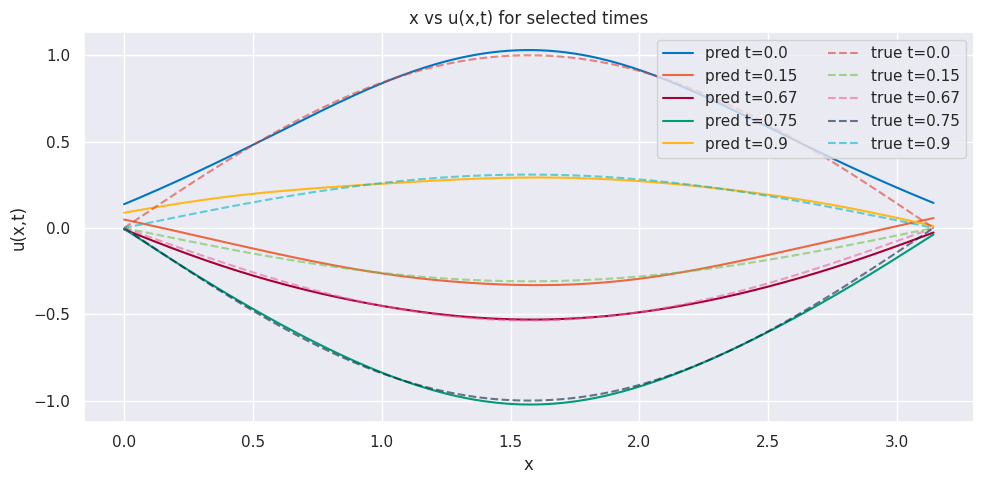

In [18]:
# Plot x vs u(x,t) for multiple time instants using the trained model
import math
import torch
import matplotlib.pyplot as plt

def plot_x_vs_u_at_times(model, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)
    x = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
    curves = []
    with torch.no_grad():
        for t_val in times:
            t = torch.full_like(x, float(t_val)).to(device)
            x_norm = x_normalizer.normalize(x)
            t_norm = t_normalizer.normalize(t)
            u_pred_output_norm = model(torch.cat([x_norm, t_norm], dim=1))
            u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)
            curves.append((t_val, x.squeeze().cpu(), u_pred_output_denorm.squeeze().cpu()))

    plt.figure(figsize=(10,5))
    for t_val, x_cpu, u_cpu in curves:
        plt.plot(x_cpu.numpy(), u_cpu.numpy(), label=f"pred t={t_val}")

    # Optional exact solution overlay if u(x,t) is defined above
    if with_exact and 'u' in globals():
        for t_val in times:
            x_t = torch.linspace(0.0, L_local, Nx).view(-1,1).to(device)
            t_t = torch.full_like(x_t, float(t_val)).to(device)
            u_true = u_exact(x_t, t_t).detach().cpu().squeeze()
            plt.plot(x_t.squeeze().cpu().numpy(), u_true.numpy(), '--', alpha=0.6, label=f"true t={t_val}")

    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title('x vs u(x,t) for selected times')
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

# Run the plot for default times
plot_x_vs_u_at_times(pinn, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=300, L_val=L, with_exact=True)

In [19]:
Nx, Nt = 200, 200
xv = np.linspace(0, np.pi, Nx)
tv = np.linspace(0, 1, Nt)
X, T = np.meshgrid(xv, tv, indexing="ij")          # X,T shape: (Nx, Nt)

xg = torch.tensor(X.reshape(-1, 1), dtype=torch.float32, device=device)
tg = torch.tensor(T.reshape(-1, 1), dtype=torch.float32, device=device)

xg_n = x_normalizer.normalize(xg)
tg_n = t_normalizer.normalize(tg)

with torch.no_grad():
    u_n = pinn(torch.cat([xg_n, tg_n], dim=1))

u_pred = u_normalizer.denormalize(u_n).cpu().numpy().reshape(Nx, Nt)
u_true = u_exact(xg, tg).cpu().numpy().reshape(Nx, Nt)
R_u = np.linalg.norm(u_pred - u_true) / np.linalg.norm(u_true) * 100

print(f"Grid relative error (u):     {R_u:.6f}%")

Grid relative error (u):     5.644694%
